## Custom automatic differentiation

In `Qiboml` we inherit the `backend` mechanism introduced in `Qibo`, extending it to the possibility of executing our quantum circuits on a specific engine indipendently of the choice of the high-level interface. 

This means you can decide to work with TensorFlow, or Pytorch, or others, depending on your personal preference, while keeping the possibility to freely set any `Qibo` backend for the circuit's execution.

Moreover, we allow free choice of the differentiation rule to be used, which can be selected among the available differentiation rules implemented in `Qiboml`.

A schematic representation of the pipeline follows, where we use as an example the custom differentiation rule of TensorFlow.
<center><img src="../public/customdiff.svg" alt="drawing" width="1000"/></center>

In practice, one defines the problem setup by setting the `Qibo` backend as usual. Let's set `tensorflow`.

In [235]:
import time
from copy import deepcopy

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from qibo import set_backend
from qibo import Circuit, gates, hamiltonians

from qiboml.operations import differentiation, expectation

from importlib import reload
reload(expectation)

<module 'qiboml.operations.expectation' from '/home/matteo/Documents/PhD/qibogang/qiboml/src/qiboml/operations/expectation.py'>

In [236]:
set_backend("tensorflow")

[Qibo 0.2.7|INFO|2024-04-22 18:17:14]: Using tensorflow backend on /device:CPU:0


Now let's setup a simple problem. We build a quantum circuit $U$ composed of some rotations and we compute the gradients of
$$ \langle 0 | U^{\dagger} O U | 0 \rangle, $$
where $O$ is an observable.

In [282]:
# circuit
nqubits = 3
nlayers = 3

c = Circuit(nqubits)
for _ in range(nlayers):
    for q in range(nqubits):
        c.add(gates.RY(q=q, theta=0))
        c.add(gates.RZ(q=q, theta=0))
c.add(gates.M(*range(nqubits)))

print(c.draw())

q0: ─RY─RZ─RY─RZ─RY─RZ─M─
q1: ─RY─RZ─RY─RZ─RY─RZ─M─
q2: ─RY─RZ─RY─RZ─RY─RZ─M─


In [286]:
# set random parameters
nparams = len(c.get_parameters())

In [284]:
# an observable
obs = hamiltonians.Z(nqubits=nqubits)

In [285]:
# compute the expectation value
final_state = c(nshots=1000).state()

print(obs.expectation(final_state))

tf.Tensor(1.5517656244439153, shape=(), dtype=float64)


In [274]:
exp = expectation.expectation(
    observable=obs,
    circuit=c,
    backend="numpy",
    differentiation_rule=differentiation.parameter_shift
)

print(exp)

tf.Tensor(1.522, shape=(), dtype=float64)


To check if we are actually changing backend, we can compute a certain number of times the expectation value, and plot the time of execution of different backend engines, such that `tensorflow` or `numpy`.

In [275]:
np_times, tf_times = [0.], [0.]
nexec = 500

for n in range(nexec):
    # some logging messages
    if (n%100==0):
        print(f"{n}/{nexec} exec")
    
    # executing on numpy backend
    it = time.time()
    expectation.expectation(
        observable=obs,
        circuit=c,
        backend="numpy",
        differentiation_rule=differentiation.parameter_shift
    )
    ft = time.time()
    np_times.append((ft-it)+np_times[-1])

    # executing on tensorflow backend
    it = time.time()
    expectation.expectation(
        observable=obs,
        circuit=c,
        backend="tensorflow",
        differentiation_rule=differentiation.parameter_shift
    )
    ft = time.time()
    tf_times.append((ft-it)+tf_times[-1])

0/500 exec
100/500 exec
200/500 exec
300/500 exec
400/500 exec


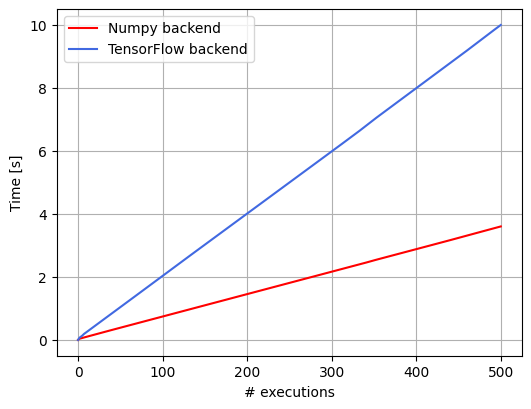

In [276]:
plt.figure(figsize=(6, 6*6/8))
plt.plot(np_times, color="red", label="Numpy backend")
plt.plot(tf_times, color="royalblue", label="TensorFlow backend")
plt.legend()
plt.xlabel("# executions")
plt.ylabel("Time [s]")
plt.grid(True)
plt.show()

This behaviour is expected, since TensorFlow is typically slower than the Numpy backend in executing circuits. It is clear, here, that setting the backend engine to `numpy`, even setting the `frontend` as `tensorflow`, is more convenient.

### Optimization example

In the following, we optimize the parameters of the parametric circuit to minimize a target cost function, which is the expectation value of a target hamiltonian. We will repeat this twice, using the `parameter_shift_rule` as differentiation method and both `numpy` and `tensorflow` as backends.

In [277]:
def cost_function(parameters, circuit, hamiltonian, backend):
    """
    Compute expectation value of ``hamiltonian`` over the final state we 
    get executing ``circuit`` using ``parameters``.
    """

In [278]:
reload(expectation)

<module 'qiboml.operations.expectation' from '/home/matteo/Documents/PhD/qibogang/qiboml/src/qiboml/operations/expectation.py'>

In [295]:
learning_rate = 0.01
nepochs = 100

# set random generator seed
np.random.seed(42)
params = tf.Variable(np.random.uniform(0, 2*np.pi, nparams))

it = time.time()
for epoch in range(nepochs):
    with tf.GradientTape() as tape:
        c.set_parameters(params)
        cost = expectation.expectation(
                observable=obs,
                circuit=c,
                backend="numpy",
                differentiation_rule=differentiation.parameter_shift
            )
    if (epoch % 10 == 0):
        print(f"Cost: {round(cost, 4)} \t |\t Epoch: {epoch}")
    gradients = tape.gradient(cost, params)
    init_params = params.assign_sub(learning_rate * gradients)
ft = time.time()

numpy_time = ft - it

Cost: 1.522 	 |	 Epoch: 0
Cost: 1.042 	 |	 Epoch: 10
Cost: 0.446 	 |	 Epoch: 20
Cost: -0.106 	 |	 Epoch: 30
Cost: -0.524 	 |	 Epoch: 40
Cost: -1.098 	 |	 Epoch: 50
Cost: -1.442 	 |	 Epoch: 60
Cost: -1.84 	 |	 Epoch: 70
Cost: -2.106 	 |	 Epoch: 80
Cost: -2.386 	 |	 Epoch: 90


Let's now repeat the same optimization but using `tensorflow` as backend.

In [297]:
# set random generator seed
np.random.seed(42)
params = tf.Variable(np.random.uniform(0, 2*np.pi, nparams))

it = time.time()
for epoch in range(nepochs):
    with tf.GradientTape() as tape:
        c.set_parameters(params)
        cost = expectation.expectation(
                observable=obs,
                circuit=c,
                backend="tensorflow",
                differentiation_rule=differentiation.parameter_shift
            )
    if (epoch % 10 == 0):
        print(f"Cost: {round(cost, 4)} \t |\t Epoch: {epoch}")
    gradients = tape.gradient(cost, params)
    init_params = params.assign_sub(learning_rate * gradients)
ft = time.time()

tensorflow_time = ft - it

Cost: 1.556 	 |	 Epoch: 0
Cost: 1.06 	 |	 Epoch: 10
Cost: 0.602 	 |	 Epoch: 20
Cost: -0.104 	 |	 Epoch: 30
Cost: -0.584 	 |	 Epoch: 40
Cost: -1.106 	 |	 Epoch: 50
Cost: -1.588 	 |	 Epoch: 60
Cost: -1.916 	 |	 Epoch: 70
Cost: -2.142 	 |	 Epoch: 80
Cost: -2.302 	 |	 Epoch: 90


In [298]:
print(f"Optimization time with tf: {tensorflow_time}")
print(f"Optimization time with np: {numpy_time}")

Optimization time with tf: 70.71000385284424
Optimization time with np: 13.57430362701416
